## 오늘의 목표          

- Exploration 노드에 나온 openCV 활용방법 복습하기

## Exp 3. 카메라 스티커앱 만들기 첫걸음

#### 전처리 - 이미지를 불러와서 리사이징하기          

> Q1. 이미지 하나를 불러와서 아래의 코드에 적용해 봅시다 :)....

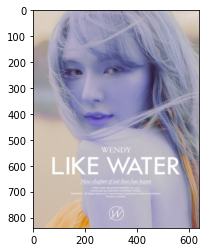

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

#이미지 경로
my_image_path = './PostingPic/wendy.jpg'

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 840))    # 640x360의 크기로 Resize

img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

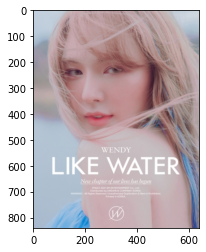

In [10]:
img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 

img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

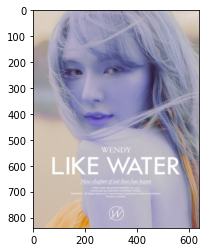

In [8]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Exp 10. 인물사진 모드                  

> Q2. 아래의 소스코드는 무엇을 하는 코드인가요? CV는 쬐금 나오지만.. 어..쨌든... 한번 되짚어봅시다.

In [12]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf


import os

#웬디 이미지로 교체
img_path = './PostingPic/wendy.jpg'

img_orig = cv2.imread(img_path)
print('세로, 가로, 채널')
print (img_orig.shape)

세로, 가로, 채널
(500, 358, 3)


In [13]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [14]:
#가중치 불러오는 내용인데 점점 cv랑 멀어지는 내용이지만..
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')

if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac23/aiffel/human_segmentation/models
model loaded successfully!


In [17]:
#이미지를 위의 네트워크에 통과시킵니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, '--->', img_resized.shape, seg_map.max())

(500, 358, 3) ---> (513, 367, 3) 15


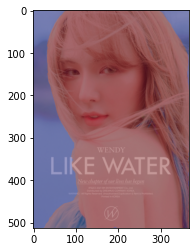

In [18]:
#마스크 만들기...! 사람은 15번이래요.
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

##### 이 문법 기억하시죠?

> Q3. 주석 달아 달라는 이야기입니다.... ㅋㅋㅋ 아래의 코드에서 각 옵션들이 어떤 의미었는지 기억하시리라 믿어요!
> 각 함수들이 어떻게 작용하고 왜 필요한 것인지 개념을 정리해주세요.

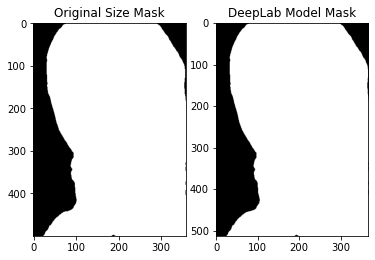

In [32]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

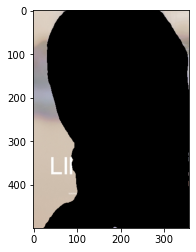

In [33]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

### 배경 흐리게 처리하기

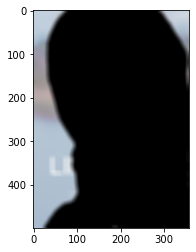

In [34]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경과 사람 합성하기

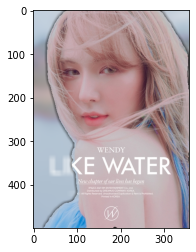

In [35]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Fund 20. 파이썬으로 이미지파일 다루기

### Pillow를 설명하더군요. 집어왔습니다.

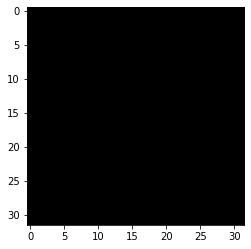

In [23]:
import numpy as np
from PIL import Image 

#cv로 들어가기 전에, Pillow의 Image 함수로 만들어진 아래 코드를 한번 실습해봅시다.
data = np.zeros([32, 32, 3], dtype=np.uint8)
image = Image.fromarray(data, 'RGB')

#image.show()
plt.imshow(image)

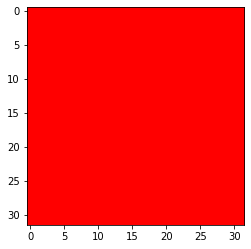

In [24]:
data[:, :] = [255, 0, 0]
image = Image.fromarray(data, 'RGB')

#image.show()
plt.imshow(image)

In [44]:
print(data)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


> Q4. 가로 세로 각 128 픽셀짜리 흰색 이미지를 만들어 화면에 표시해 봅시다.

[[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]


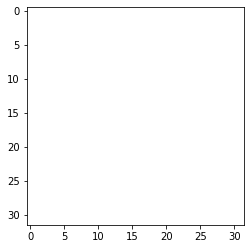

In [45]:
#data = np.zeros([32, 32, 3], dtype=np.uint8)
#모든 픽셀을 동일한 색깔로 표시하도록 함.

data[:, :] = [255, 255, 255]
image = Image.fromarray(data, 'RGB')

#image.show()
plt.imshow(image)

#print(data)
print(data[0])

> Q5. 연습용 이미지를 열어 width와 height를 출력하고, .save()를 이용하여 jpg 파일 포맷으로 저장해 봅시다.

In [39]:
load_image_path = './PostingPic/apples.jpg'

apple = cv2.imread(load_image_path)

print('가로, 세로, 채널')
print(apple.shape[1], apple.shape[0], apple.shape[2])

가로, 세로, 채널
732 549 3


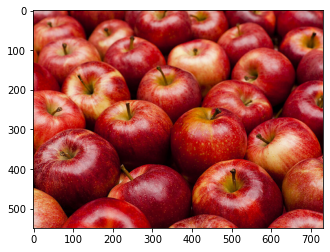

In [43]:
apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB) 
plt.imshow(apple)

#저장하는 메소드?
import os

### 펀더멘탈에서 설명하는 openCV

> Q6. 각 코드를 설명해주세요!

In [ ]:
import cv2 as cv
import numpy as np

cap = cv.VideoCapture(0)

while(1):

    # 비디오 캡쳐하여 결과 _, 장면 frame 을 반환하기
    _, frame = cap.read()

    # RGB를 또다른 컬러 채널인 HSV 로 변경하기
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    # HSV에서 파란색 채널 을 뽑아냄(예전에 했던 것 기억하시나요)
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv, lower_blue, upper_blue)

    # Bitwise-AND mask and original image
    res = cv.bitwise_and(frame,frame, mask= mask)
    cv.imshow('frame',frame)
    cv.imshow('mask',mask)
    cv.imshow('res',res)
    k = cv.waitKey(5) & 0xFF
    if k == 27:
        break

cv.destroyAllWindows()
cap.release()

### CV를 활용하여 비슷한 색깔 분포의 이미지 찾아내기              

- 서로 다른 이미지 10장을 준비해주세요.

> - Q7. 아래 가이드 페이지를 참고하여 입력한 이미지의 색상별 히스토그램을 반환하는 함수를 작성해봅시다.
> - [가이드페이지](https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html)

In [58]:
load_image_path = './PostingPic/apples.jpg'

#For me I had to change from
#img = cv2.imread('image.jpg', 0)

img = cv2.imread('image.jpg')
The 0 is an imreadModes asking cv to read the image the greyscale mode.
apple = cv2.imread(load_image_path)
hist = cv2.calcHist([apple],[0],None,[256],[0,256])

#print(hist)

hist,bins = np.histogram(apple.ravel(),256,[0,256])

print(apple.ravel())

#print(hist)
#print(bins)

#plt.show()

[166 169 220 ... 105 120 223]


0
1
2


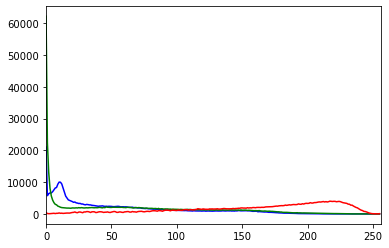

In [59]:
#img.ravel()
#flatten()

color = ('b','g','r')

for i,col in enumerate(color):
    print(i)
    histr = cv2.calcHist([apple],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

#hist = cv2.calcHist(images, channels, mask, histSize, ranges(, hist(, accumulate)))